In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# FE'li dataset
df = pd.read_csv("../data/processed/train_fe.csv")
print("FE dataset shape:", df.shape)

# Hedef ve feature
y = df["TARGET"]
X = df.drop(columns=["TARGET"])

# Kategorik kolonlar
cat_cols = X.select_dtypes(include=["object"]).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Aynı split mantığı: (random_state, test_size, stratify aynı olursa öncekiyle tutarlı olur)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)

# Final modeli yükle (04. notebook'ta kaydetmiştik)
final_model = joblib.load("../models/final_model.pkl")
print("Model loaded.")


FE dataset shape: (307511, 134)
Train: (246008, 133) Val: (61503, 133)
Model loaded.


In [2]:
val_proba = final_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, val_proba)
print(f"FINAL MODEL ROC-AUC (Validation): {final_auc:.4f}")


FINAL MODEL ROC-AUC (Validation): 0.7692


In [3]:
threshold = 0.5
val_pred = (val_proba >= threshold).astype(int)

cm = confusion_matrix(y_val, val_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_val, val_pred, digits=4))


Confusion Matrix:
 [[56457    81]
 [ 4849   116]]

Classification Report:

              precision    recall  f1-score   support

           0     0.9209    0.9986    0.9582     56538
           1     0.5888    0.0234    0.0449      4965

    accuracy                         0.9198     61503
   macro avg     0.7549    0.5110    0.5016     61503
weighted avg     0.8941    0.9198    0.8844     61503



In [4]:
importances = final_model.feature_importances_
features = X.columns

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df.head(20)


,feature,importance
127,CREDIT_ANNUITY_RATIO,298
129,PAYMENT_RATE,290
42,EXT_SOURCE_3,222
16,DAYS_BIRTH,189
40,EXT_SOURCE_1,177
130,EXT_SOURCE_MEAN,171
19,DAYS_ID_PUBLISH,170
17,DAYS_EMPLOYED,169
132,EXT_SOURCE_MAX,166
131,EXT_SOURCE_MIN,154


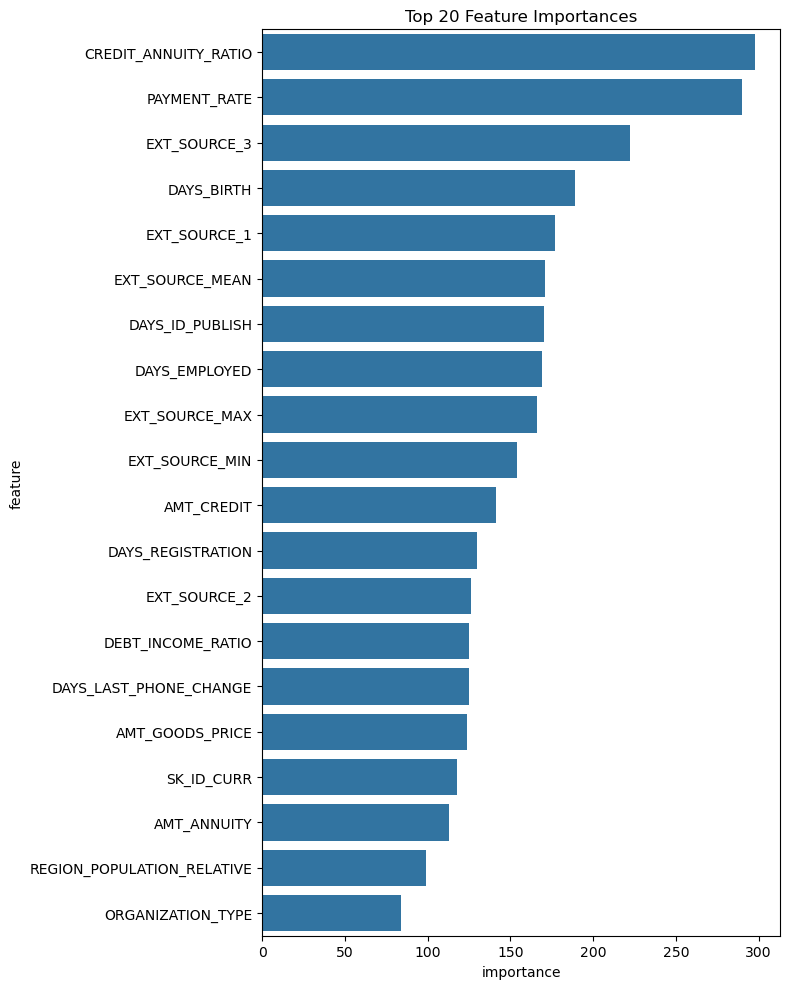

In [5]:
plt.figure(figsize=(8,10))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()
